In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bienvenidos al proyecto integrador de [Rodrigo Guarneros](https://github.com/RodGuarneros)
## **Maestría en Ciencia de Datos e Información**
## **Centro de Investigación e Innovación en Tecnologías de la Información y Comunicación (INFOTEC)**


#### El objetivo es utilizar los datos disponibles en la plataforma kaggle en el marco del concurso [Titanic - Machine Learning from Disaster](http://www.kaggle.com/competitions/titanic/overview).

#### A través de conocimientos básicos de *Machine Learning*, se utilizan los datos de los pasajeros de la famosa embarcación para predecir quién sobrevivirá y quién no. En otras palabras, se creará un modelo de aprendizaje automático con la capacidad de predecir si un pasajero sobrevivirá en función de sus características (nombre, edad, precio del boleto, *etc*.).

Para cumplir con este propósito, se llevarán a cabo los procedimientos estándar, tomando en cuenta lo aprendido durante el curso propedéutico.

- Paso 1: Extracción de la información
- Paso 2: Transformación de los datos
- Paso 3: EDA, Análisis exploratorio de datos
- Paso 4: Pre-Procesamiento
- Paso 5: Definiendo y entrenando el modelo, haciendo predicciones y evaluando precisión
- Paso 6: Proveer características de tres sujetos, en ellos incluido el que escribe y ver quién se hundiría y quién no. Ya vimos esa película, pero confirmemos.

In [185]:
# Dependencias
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as sts
# Pre-procesamiento y modelación
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import math
import pickle

## <span style="color:blue">Paso 1 *(Extracción de los datos)*:</span>

En este primer paso, comenzamos con la primera parte del ciclo Extracción, Transformación y Carga de la información (ETL, por sus siglas en inglés).

Basados en la [descripción de los datos](https://www.kaggle.com/competitions/titanic/data) existen tres archivos csv para el ejercicio: 

- test.csv
- train.csv
- gender_submission.csv




In [4]:
# Obteniendo los marcos de datos disponibles (Extracción de información)
X_train_full = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
X_test_full = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv', index_col='PassengerId')

## <span style="color:blue">Paso 2 *(Transformación de los datos)*:</span>

A partir de un análisis exploratorio de los datos (EDA, por sus siglas en inglés), busquemos las particularidades de la información disponible.

Basados en el siguiente análisis se pueden constatar las variables disponibles en cada conjunto de datos, su dimensión, así como sus principales características:

- X_train_full
    - **891** pasajeros y 11 variables: Status de supervivencia (0 fallecid@, o 1 viv@), Clase, Nombre, Sexo, Sibsp, Parch, Ticket, Fare, Cabina y Embarcado.
- X_test_full
    - **418** pasajeros y 10 variables. Las mismas variables que el conjunto de datos de entrenamiento, excluyendo la variable "Survived" para efectos de no contar con esta información en el contexto de la competencia.
- gender_submission
    - Se trata de un ejemplo sobre cómo se vería el resultado que se enviará al concurso, basado en hipótesis de género: El status de supervivencia para los **418** pasajeros es que sólo sobrevivieron las mujeres. 
    
Para mejor comprensión de los datos se incluye aquí el diccionario tomado de la descripción del caso, en la seccion de [datos](https://www.kaggle.com/competitions/titanic/data):

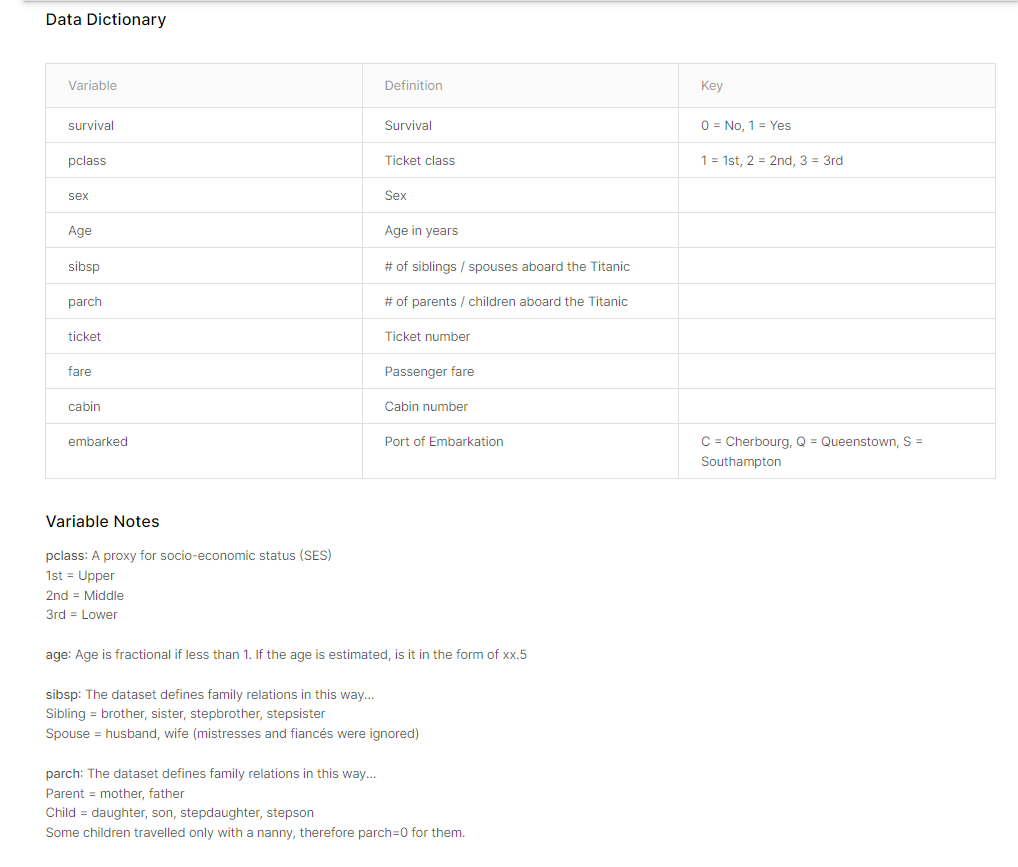

In [5]:
X_train_full

In [6]:
X_test_full

In [7]:
gender_submission

In [8]:
X_train_full.dtypes

In [9]:
X_test_full.dtypes

# Exploremos los **missing values**

En un primer vistazo: ¿Existen columnas que deberían eliminarse por tener un número considerable de missing values y cuya pérdida de información implica que no puede imputarse fácilmente?

In [10]:
# ¿Qué columnas tienen missings en cada conjunto de información?

columnas_con_missings_train = [col for col in X_train_full.columns if X_train_full[col].isnull().any()]
columnas_con_missings_train
print(f'Las columnas con missings en el conjunto de entrenamiento son:{columnas_con_missings_train}')
columnas_con_missings_test = [col for col in X_test_full.columns if X_test_full[col].isnull().any()]
columnas_con_missings_test
print(f'Las columnas con missings en el conjunto de prueba son:{columnas_con_missings_test}')

In [11]:
# ¿Qué magninud (porcentaje de la información) está pérdida en cada una de las columnas antes señaladas?
porcentaje_missings_train = X_train_full.isnull().sum()/len(X_train_full)*100

porcentaje_missings_test = X_test_full.isnull().sum()/len(X_test_full)*100

print(f'Porcentaje de missings en el conjunto de entrenamiento: {porcentaje_missings_train}')
print(f'Porcentaje de missings en el conjunto de prueba: {porcentaje_missings_test}')

El resultado anterior sugiere que la variable "Cabin" tiene un porcentaje muy alto de valores perdidos (77% para el conunto de entrenamiento y 78% para el de prueba). Situación que de acuerdo a la literatura excede el máximo de missings aceptable (entre 60% y 70%), aunque hablando de manera genérica no hay una regla exacta.

Para el caso de la variable "Edad" y "Embarked" se sugieren porcentajes de missing values que pueden ser imputados, tomando en cuenta también el valor de la información que proporcionan y que podrían considerarse como "features" o predictores relevantes: **Edad y puerto de embarque**, además de que continuan proporcionando un porcentaje importante de información que podría aprovechar el modelo.

In [12]:
# Eliminando la variable "Cabin"

X_train_full = X_train_full.drop(['Cabin'], axis=1)
X_test_full = X_test_full.drop(['Cabin'], axis=1)


In [13]:
# El resto de las observaciones (pasajeros), sólo registran 1 missing value en la edad. No hay observaciones on más de dos imputaciones.
# Aplica exactamente lo mismo para el caso del conjunto de datos de prueba.

X_train_full[X_train_full.isnull().any(axis=1)>=1] # 179 de los 891 registros, equivalente al 20.0%
X_test_full[X_test_full.isnull().any(axis=1)>=1] # 87 de los 418 registros, equivalente al 20.8%

# Variables categóricas.

**En el contexto de los datos:**

**"Embarked"** podría incluir información relevante considerando que señala en cuál de los tres puertos que visitó el Titanic antes de su larga travesia hacia NYC y su inesperado hundimiento. Puertos donde subieron más pasajeros, obtuvó viveres y consumibles, en orden cronológico: 

- El Titanic zarpó de Southampton, Inglaterra, el 10 de abril de 1912 (viaje inaugural). 
- Se detuvo en Cherburgo en Francia, y 
- Queenstown en Irlanda 

En estos dos últimos puertos para recoger pasajeros, tripulación y suministros.

In [14]:
# Las variables categóricas son: Pclass, Sex, Número de herman@s/Espos@s (SibSp), Relaciones familiares (Parent or child, Parch) y Embarked
# sin embargo, algunas tienen valores numéricos, como es el caso de Survived, Pclass, SibSp y Parch. Esta misma estructura aplica también para el marco de datos "X_test_full" 
# Aquí vamos a transformar esas variables en ambos conjuntos de datos en variables categóricas. 
X_train_full.dtypes


In [15]:
X_test_full.dtypes

### De las **9 variables o features disponibles, 6 son categóricas**. Para ser consistentes con los requerimientos de los modelos e identificar adecuadamente las variables categóricas (regularmente identificadas como typo objeto u "object") y las numéricas (identificadas como "int64" o "float64"), pero iniciemos con la identificación de los valores categóricos en estas variables para efectos de evaluar cuál debería ser el tipo de encoding a utilizar en la fase de pre-procesamiento.

In [16]:
# para el conjunto de entrenamiento, se puede ver que las "categorías no son tan amplias" y no tendríamos 
# un problema de dimsensiones si se considera que un encoding de one-hot crea una nueva columna por categoría: 
# Las más amplias son SibSp (# de herman@s o espos@s a bordo) y Parch (número de parientes o hijos a bordo), 
# variables en las cuales el orden no es tan importante, excluyendo de la ordinalidad a la clase a la que pertenecía 
# el pasajero (Pclass, 1a, 2a, o 3a): 

categorical = ['Sex','Survived', 'Pclass', 'SibSp', 'Parch', 'Embarked']
                       
for i in categorical:
    unique = X_train_full[i].unique()
    print(i, unique)
# En virtud de lo anterior, y tomando en cuenta la redomendación recibida durante el curso, utilizar one-hot encode 
# cuando se tienen variables con menos de 15 valores diferentes, umbral que se cumple para todas las variables categóricas identificadas.

In [17]:
# En el caso del conjunto de datos X_test_full, se observa un comportamiento similar

categorical2 = ['Sex','Pclass', 'SibSp', 'Parch', 'Embarked']
                       
for i in categorical2:
    unique = X_test_full[i].unique()
    print(i, unique)


In [18]:
# Para efectos de garantizar el tratamiento adecuado de las variables categóricas cuando comencemos el pre-procesamiento de los datos
# se transforman cuatro variables en categóricas (Survived, Pclass, SibSp, Parch) pues si las dejamos como variables numéricas corremos 
# el riesgo de un cálculo erróneo del modelo.

categorias_numéricas =  ['Survived', 'Pclass', 'SibSp', 'Parch']
                       
for i in categorias_numéricas:
    X_train_full[i] = X_train_full[i].astype(object)
    
X_train_full.dtypes

In [19]:
# Se repite el tratamiento para X_test_full

categorias_numéricas =  ['Pclass', 'SibSp', 'Parch']
                       
for i in categorias_numéricas:
    X_test_full[i] = X_test_full[i].astype(object)
    
X_test_full.dtypes

Estamos listos para iniciar el pre-procesamiento de los datos con miras a la elección del modelo, el encoding de las variables categóricas y la imputación de missing values.

Recordando que el ***One-Hot Encoding*** es capaz de codificar características categóricas correctamente, a pesar de algunos inconvenientes menores. Específicamente, la presencia de una gran cantidad de valores binarios no es ideal para los algoritmos basados en la distancia, como los modelos de agrupamiento. Además, la gran cantidad de características generadas adicionalmente introduce la maldición de la dimensionalidad. Esto significa que debido a la alta dimensionalidad del conjunto de datos, el conjunto de datos se vuelve mucho más escaso. En otras palabras, en los problemas de Machine Learning, necesitaría al menos algunas muestras para cada combinación de funciones. Aumentar el número de características significa que podríamos encontrar casos de no tener suficientes observaciones para cada combinación de características

## <span style="color:blue">Paso 3 *(EDA, Análisis exploratorio de datos)*:</span>

Vamos a familiarizarnos más con los datos, respondamos algunas preguntas básicas como: ***¿Qué relación tiene la variable que indica si sobrevivió o no un pasajero y las otras variables disponibles, como es el caso de la variable de la clase en la que estaba el pasajero, el precio del boleto, la edad, el sexo, el lugar de procedencia, etc.?***

In [20]:
# Sólo tenemos dos variables numéricas: Edad y Costo del boleto. Sólo por curiosidad, hagamos la relación:

g = sns.FacetGrid(X_train_full, col="Survived", hue="Sex")
g.map(sns.scatterplot, "Age", "Fare", alpha=.7)
g.add_legend()

Sugiere que la proporción de supervivientes del sexo femenino es mayor.

In [21]:
g = sns.FacetGrid(X_train_full, row='Sex', col="Survived", hue="Pclass")
g.map(sns.scatterplot, "Age", "Fare", alpha=.7)
g.add_legend()

En el caso de las mujeres, es muy evidente que la mayoría de las pasajeras de primera y segunda clase se salvaron, mientras que una proporción considerable de las mujeres de tercer clase no se salvaron. En el caso de los hombres, la tendencia es muy similar aunque menos marcada: La tercera clase, en el caso de los hombres, únicamente admitió a menores de 45 años aproximadamente en una proporción menor.

En conclusión pareciera que la clase del pásajero fue un factor clave en el caso de las mujeres, aunque no es tan claro en el caso de los hombres.

In [22]:
g = sns.FacetGrid(X_train_full, row='Pclass', col="Survived", hue="Sex")
g.map(sns.scatterplot, "Age", "Fare", alpha=.7)
g.add_legend()

La edad no pareció ser un driver para el caso de la primera clase, tanto para hombres como para mujeres, donde también se confirma que las mujeres fueron la mayor proporción de sobrevivientes, aunque en menor medida que en el caso de la segunda clase, donde el criterio del género fue crucial. En el caso de la tercera clase, parece que el criterio más relevante fue la edad y después el sexo, generando una proporción casi similar entre los sobrevivientes y no sobrevivientes entre los cero y 50 años. Mientras que los hombres mayores de 50 años en la tercera clase no tuvieron cabida en los botes salvavidas.En tanto que en el caso de segunda y tercera clase, sí hubo sus excepciones de edad, e incluso en el caso de la prime clase, parece que no fue un criterio.

In [23]:
# En el caso de los herman@s o espos@s a bordo. ¿Existió un criterio donde se salvaron familias o hubo una selección en los botes salvavidas independiente de que dijeras que tu familia iba en el bote?
g = sns.FacetGrid(X_train_full, row='Survived', col="SibSp", hue='Pclass')
g.map(sns.scatterplot, "Age", "Fare", alpha=.7)
g.add_legend()

No hay un patrón claro de que al aumentar el número de Hermanos o si estaba casado existiera una mayor probabilidad de sobrevivir. Se trata de un criterio que posiblemente no se consideró al momento de seleccionar quién debería subir a un bote salvavidas.

In [24]:
# De igual forma, en el caso de los que viajaban con sus padres o hijos a bordo. ¿Existió un criterio donde se salvaron familias o hubo una selección en los botes salvavidas 
# independiente de que dijeras que tu familia iba en el bote?
g = sns.FacetGrid(X_train_full, row='Survived', col="Parch", hue='Pclass')
g.map(sns.scatterplot, "Age", "Fare", alpha=.7)
g.add_legend()

Los pasajeros niños que viajaban con sus nanas tuvieron oportunidad de sobrevivir en el caso de la primera clase y en menor proporción los de tercera clase, al igual que los que viajaban con uno de sus padres o hijo.

## **Cuantifiquemos estas relaciones**
- ¿De qué proporciones hablamos?
- ¿Cómo se distribuyen estas variables?
- ¿Qué relaciones lineales se pueden identificar?

A parentemente los determinantes más interesantes de sobrevivencia, son los criterios de **Edad, Clase en la que viajaba el pasajero y Sexo**. No obstante, no se descartan las relaciones familiares, el puerto de embarque y demás variables disponibles.

In [25]:
X_train_full.info()

# Sobrevivir vs. Género

Con ayuda de una tabla de contingencia también se tiene información relevante:

- Del total de pasajeros registrados en el conjunto completo de entrenamiento (891), se tiene que el 38% del total de pasajeros registrados en el conjunto de entrenamiento sobrevivieron 
- 35% de todos los pasajeros eran mujeres de edades que van de los 0.75 años a los 63 años, un promedio de edad de 28 años y una mediana de 27 años.
- 65% de todos los pasajeros eran hombres de edades que van de los 0.42 años a los 80 años, un promedio de edad de 30.7 años y una mediana de 29 años.
- Del total de Sobrevivientes, el 68% fueron mujeres y el 32% restante fueron hombres.
- En sentido inverso, en el subconjunto de pasajeros que perdieron la vida se contabiliza que el 85% eran hombres y el 15% eran mujeres. 

**Estos dos últimos datos obtenidosa continuación y visualizados, sugieren que la variable sexo podría tener una importante contribución para explicar la probabilidad de sobrevivir al Titanic. Donde es claro que las mujeres fueron prioridad en el proceso de salvamento**

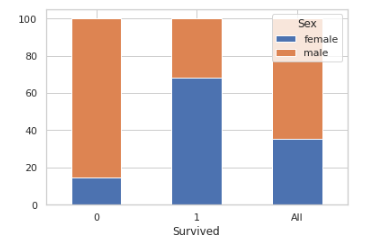

In [26]:
# Sobrevivir vs Sexo

pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Sex'], margins=True, normalize='index')\
    .round(4)*100

In [27]:
X_train_full[X_train_full['Sex']=='female'].describe()

In [28]:
X_train_full[X_train_full['Sex']=='male'].describe()

In [29]:
crosstab_clase = pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Sex'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

# Sobrevivir vs. Clase en la que se viajaba (1a, 2a o 3a)

Con ayuda de una tabla de contingencia también se tiene información relevante:

- Del total de pasajeros registrados en el conjunto completo de entrenamiento (891), se tiene que 216 pertenecían a primera clase, 184 a segunda clase y 491 a tercera clase. 
- De este universo, el mayor porcentaje de participación entre los sobrevivientes es de la primera clase (39.77% de todos los sobrevivientes), seguido de la tercera clase (34.8%) y la segunda clase (34.8%). 
- En cuanto a los pasajeros que perdieron la vida, en general se tiene que la tercera clase domina el porcentaje de participación con el 67.76%, mientras que la participación en esta categoría por parte de primera y segunda clase son relativamente bajos (14.57% y 17.67%, respectivamente).
- Otra forma de verlo y como se puede constatar abajo es que, independientemente del sexo u otra característica de la tripulación del Titanic:
    - El 37% de la tripulación que viajaba en primera clase perdió la vida.
    - El 53% de la tripulación que viajaba en segunda clase perdió la vida.
    - El 62% de la tripulación que viajaba en tercera clase perdió la vida.

**Estos últimos datos obtenidos a continuación y visualizados, sugieren que la variable clase podría tener una importante contribución para explicar la probabilidad de sobrevivir al Titanic, mostrando que las posibilidades de sobrevivir aumentaban en función de la clase en la que se viajaba.**

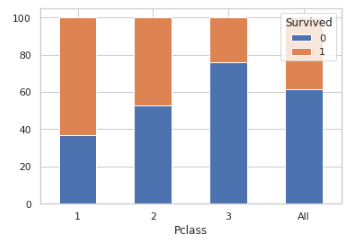

In [30]:
# Sobrevivir vs. clase en que se viajaba
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Pclass'], margins=True)

In [31]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Pclass'], margins=True, normalize='index')\
    .round(4)*100

In [32]:
pd.crosstab(index=X_train_full['Pclass'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

In [33]:
crosstab_clase = pd.crosstab(index=X_train_full['Pclass'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

# Sobrevivir vs. Lugar de embarque

Con ayuda de una tabla de contingencia también se tiene información relevante:

- Del total de pasajeros registrados en el conjunto completo de entrenamiento (891), se tiene que 644 embarcaron en Southhamton, 168 en Cherbourg y 77 en Queenstown. Sólo dos de esos pasajeros no se tiene registro de embarque. 
- De este universo, el mayor porcentaje de participación entre los sobrevivientes se encuentra en Cherbourg (55.33% de los pasajeros que abordaron en Cherbourg sobreviven), en tanto que los pasajeros que abordaron en Queenstown y Southhamton tienen un porcentaje de sobrevivientes relativamente bajo (38.9% y 36.7% respectivamente). ***Lo anterior es de llamar la atención si consideramos que la mayor proporción de tripulates abordó en Southhamton (72.4% del total de registrados), seguido de Cherbourg (18.9%) y luego Queenstown (8.66%), lo que indica que no se trata de un patrón aleatorio y podría ser relevante para el modelo***. 

De acuerdo con esta fuente: https://www.irishcentral.com/roots/history/on-this-day-titanic-sets-sail-southampton-cherbourg-france#:~:text=Two%20hundred%20and%20eighty%2Done,famous%20passengers%20boarded%20at%20Cherbourg. Los números anteriores podrían deberse a la composición de los pasajeros que abordaron en cada puerto.

- Los que abordaron en Cherbourg, Francia, fuero 151 de primera clase, 28 de segunda clase y 102 de tercera clase.

De acuerdo con los testimoniales, los más famosos y ricos pasajeros abordaron en ese puerto.

**Estos últimos datos obtenidos a continuación y visualizados, sugieren que la variable de lugar de embarque podría tener una importante contribución para explicar la probabilidad de sobrevivir al Titanic.**


In [34]:
# Sobrevivir vs. clase en que se viajaba
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Embarked'], margins=True)

In [35]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Embarked'], margins=True, normalize='index')\
    .round(4)*100

In [36]:
pd.crosstab(index=X_train_full['Embarked'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

# Sobrevivir vs. Número de parientes o hijos en el barco

Con ayuda de una tabla de contingencia también se tiene información relevante:

- La tabla cruzada confirma que la tercera clase lleva un porcentaje mayor de pasajeros con parientes e hijos, tal y como se puede ver en la visualización.
- No es claro que el número de parientes o hijos fuera un criterio de selección para dejarte subir al bote salvavidas. No obstante, los niños que no venían acompañados de sus padre y sólo una nana, representan un mayor porcentaje de desesos.
- En la última visualización de esta sección la categoría 3 parece tener una relación más estrecha con el porcentaje de sobrevivientes, sugiriendo que el tener una hija, hijo o mamá aumentaría la probabilidad de salvarse.

**Estos últimos datos obtenidos a continuación y visualizados, no presentan un patron claro que sea de utilidad para explicar la probabilidad de sobrevivir al Titanic, lejos de que el número de parientes e hijos en el barco está asociado a la variable explicativa clase en la que se viaja y que los pasajeros con una hija representan el mayor porcentaje de salvados (60% del total de pasajeros que tenían esta relación parental).**

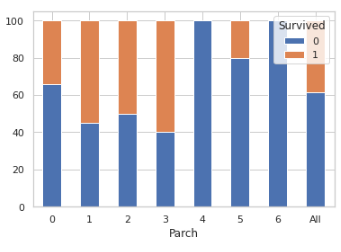

In [37]:
# Sobrevivir vs. clase en que se viajaba
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Parch'], margins=True)

In [38]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Parch'], margins=True, normalize='index')\
    .round(4)*100

In [39]:
pd.crosstab(index=X_train_full['Parch'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

In [40]:
pd.crosstab(index=X_train_full['Parch'], columns=X_train_full['Pclass'], margins=True, normalize='index')\
    .round(4)*100

In [41]:
crosstab_clase = pd.crosstab(index=X_train_full['Parch'], columns=X_train_full['Pclass'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

In [42]:
crosstab_clase = pd.crosstab(index=X_train_full['Parch'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

# Sobrevivir vs. Número de herman@s o espos@s

Con ayuda de una tabla de contingencia también se tiene información relevante:

- No es claro que el número de hermanos o hermanas, esposo o esposa, fuera un criterio de selección para dejarte subir al bote salvavidas. No obstante, el tener una hermana o hermano a bordo si que favorecía la probabilidad de salvarse, aunque con un patrón no tan evidente como en el caso de Sexo o Clase en la que se viajaba. 

**Estos últimos datos obtenidos a continuación y visualizados, presentan un patron claro para explicar la probabilidad de sobrevivir al Titanic, donde contar con un hermano o hermana en el barco genera mejores condiciones para sobrevivir.**

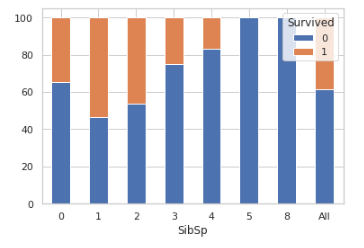

In [43]:
# Sobrevivir vs. clase en que se viajaba
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['SibSp'], margins=True)

In [44]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['SibSp'], margins=True, normalize='index')\
    .round(4)*100

In [45]:
crosstab_clase = pd.crosstab(index=X_train_full['SibSp'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

A partir de aquí exploramos las variables numéricas que cuentan con el mayor número de missing values ('Age' y 'Fare')

In [46]:
missing_val_count_by_column = (X_train_full.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Sobrevivir vs. Edad

Exploremos la variable Edad. Además, con ayuda de una tabla de contingencia también se tiene información relevante:

- Sólo 714 del total de registros que conforman el marco de datos de entrenamiento tiene un registro de la edad (80% del total).
- El promedio de edad de todos los registros es de 29.69 años, su desviación estándar es de 14.5 años.
- La edad mínima es de 0.42 años (equivalente aproximadamente a 5 meses de edad).
- La edad máxima es de 80 años y tenemos una mediana de 28 años.
- Se trata de una distribución muy bien comportada con 11 datos aberrantes por encima de los 64.8 años, de los cuales sólo 1 sobrevivió.
- La relación de la edad con la posibilidad de sobrevivir implica, de acuerdo on las tablas de contingencia, lo siguiente:
    - Del total de pasajeros que cuentan con un registro de edad (713 ó el 80% del total de registros), los adultos tienen la mayor participación (527) seguidos de los ancianos (73), los adolecentes (44) y los niños (39).
    - De los que se salvaron, el 69% eran adultos, 9% ancianos y 7% adolecentes, representando el 85% de los que sobrevivieron.
    - De los que no se salvaron, el 76.65% eran adultos, 11.08% ancianos y 5.42% adolecentes. Destaca en este caso que el porcentaje de Bebés es extremadamente bajo 0.47%. Sugiriendo que la edad fue un factor relevante. 
    - ***Lo anterior se confirma si se observa que el 85.1% de los bebés se salvaron. Mientras que los pequeños que apenas caminaban, los niños por encima de los cuatro y hasta los trece años, así como los adolencentes se salvaron en una proporción de casi 50%.*** 
    - ***Mientras que los adultos y ancianos sólo se salvaron en una proporción de 38.33% y 35.62%, respectivamente.***

**Estos últimos datos obtenidos a continuación y visualizados,  presentan un patron claro y de utilidad para explicar la probabilidad de sobrevivir al Titanic, haciendo más probable lo anterior si se trataba de bebés y menos probable para los casos como adultos y ancianos. En otras palabras, la posibilidad de sobrevivir aumentaba conforme se reducía la edad del pasajero de conformidad con los grupos de edad calculados en nuestra nueva variable categórica calculada abajo.**

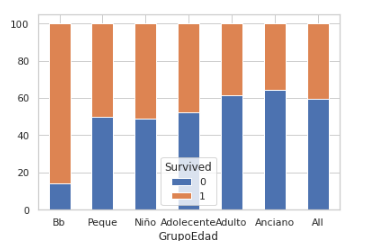

In [47]:
# Principales estadísticos de la variable edad:

X_train_full['Age'].describe()

In [48]:
# para ver cómo se comporta la distribución veamos la boxplot

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=X_train_full["Age"])

In [49]:
edades = X_train_full['Age']

plt.hist(edades)
plt.xlabel('Edades')
plt.ylabel('Frecuencia')
plt.show()
print(sts.normaltest(edades.sample(50)))

In [50]:
# calculemos la desviación estándar
sd_numpy = np.std(edades,ddof = 0) # el parámetro ddof nos permite garantizar que estamos calculando la desviación estándar poblacional.
print(f"La desviación estándar poblacional de las edades es: {sd_numpy}")

In [51]:
# calculamos la media
mean_numpy = np.mean(edades)
print(f"La media de las edades es: {mean_numpy}")


In [52]:
# Calculemos la regla 68-95-99.7 usando desviación estándar
print(f"Aproximadamente 68% de los datos está entre: {round(mean_numpy-sd_numpy,3)} and {round(mean_numpy+sd_numpy,3)}")
print(f"Aproximadamente el 95% de los datos está entre: {round(mean_numpy-2*sd_numpy,3)} and {round(mean_numpy+2*sd_numpy,3)}")
print(f"Aproximadamente el 99.7% de los datos está entre: {round(mean_numpy-3*sd_numpy,3)} and {round(mean_numpy+3*sd_numpy,3)}")

In [53]:
# buscando los aberrantes a través del método intercuartílico
quartiles = edades.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

In [54]:
print(f"El cuartil inferior de la edad es: {lowerq}")
print(f"El cuartil superior de la edad es: {upperq}")
print(f"El rango intercuartil de la edad es: {iqr}")
print(f"La mediana de la temperatura es: {quartiles[0.5]} ")

In [55]:
# El valor de 1.5 se deriva de las reglas de distribución normal. El cálculo algebráico está disponible en: 

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Valores por debajo de {lower_bound} son datos aberrantes.")
print(f"Valores por encima de {upper_bound} son datos aberrantes.")


In [56]:
# datos aberrantes

X_train_full[X_train_full['Age']>64.8]

In [57]:
#  Se trata de 11 datos aberrantes con valores que van de los 65 años a los 80 y una media de 69.77

X_train_full[X_train_full['Age']>64.8].describe()

**Hemos visto indicios de la relevancia de la edad, exploremos la tablas de contingencia, pero antes debemos crear los bins de la edad. En otras palabras, crear una variable categórica basada en los valores de la edad y considerando los siguientes valores posibles: Bebé, Niño Pequeño (comienza a caminar), Niño, Adolecente y Adulto.**

In [58]:
# Creando la categoría de edad, con base en la función cut de pandas.

bins = [0,2,4,13,18,50,80]
etiquetas = ['Bb', 'Peque', 'Niño', 'Adolecente', 'Adulto', 'Anciano']
#creando la columna
X_train_full['GrupoEdad'] = pd.cut(X_train_full['Age'], bins=bins, labels=etiquetas, right=False)
print(X_train_full['GrupoEdad'])

In [59]:
# Sobrevivir vs. clase en que se viajaba
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['GrupoEdad'], margins=True)

In [60]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['GrupoEdad'], margins=True, normalize='index')\
    .round(4)*100


In [61]:
pd.crosstab(index=X_train_full['GrupoEdad'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100


In [62]:
crosstab_clase = pd.crosstab(index=X_train_full['GrupoEdad'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

A continuación se exploran las variables numérica que curiosamente tienen también un número bajo, pero considerable de missing values en el conjunto X_train_full.



# Sobrevivir vs. Costo del boleto

**¿Comprar un boleto caro te garantizaba un mejor trato para sobrevivir?**

Por último, pero no menos importante, exploremos la variable costo del voleto (Fare). Los hechos encontrados son los siguientes:

- El valor mínimo de un boleto fue de cero. El promedio fue 32.2 Libras y el costo máximo de un boleto fue de 512.32 libras. Consistentes con los costos aproximados documentados donde se podría decir que un boleto de 7 libras por tecera clase equivaldría actualmente a 1,071 dólares, más de 20 mil pesos y un boleto de primera clase con suite en aproximadamente 870 libras, a precios actuales de 133,132 dólares o más de 2.5 millones de pesos. Para más detalle visita: https://www.cruisemummy.co.uk/titanic-ticket-prices/
- El marco de datos incluye 15 boletos con un costo de cero, se trata de personal adulto y másculino en todos los casos, por lo que se podría considerar que estos boletos pertenecían a tripulación de servicio o algo por el estilo.
- Existen 11 casos con un costo del boleto considerado como aberrante(Excede el upper bounding de la distribución calculado en 245.19 dólares, de los cuales sólo 3 perdieron la vida y los otros 8 sobrevivieron (equivalentes al 72.72% de los poseedores de estos costosos boletos).
- La edad máxima es de 80 años y tenemos una mediana de 28 años.
- La relación del costo del boleto con la posibilidad de sobrevivir implica, de acuerdo on las tablas de contingencia, lo siguiente:
    - Del subconjunto de los que no sobrevivieron, el mayor porcentaje lo representan los pasajeros que viajaban en clase popular (33.59% del total de los pasajeros que murieron) y la clase económica (29.56%), mientras que la primera clase con suite representaron el 13.6% del total de muertos.  
    - De los pasajeros que sí se salvaron, la relación se invierte para mostrar que de este subconjunto el 16.89% eran de la clase popular, el 20.5% de la clase económica; mientras que la clase que contaba con camarote (primera clase A) representó el 33.7% y el de la primera clase con suite representó el 28.8%. Lo anterior a pesar de que nuestras categorías tienen en total una representación similar cercana al 25% cada una. 
    - ***La tabla de contingencia inversa confirma que los pasajeros con boletos más económicos representan el mayor porcentaje de fallecidos (77.43% y 71.3%, respectivamente) mientras que los pasajeros con un boleto más caro (Primera clase con camarote o con suite) aumentaron su porcetaje de salvados de manera directamente proporcional con el costo del boleto (45.74% y 55%, respectivamente). Lo anterior podría explicarse por una mayor influencia en la selección de los que ocuparían los botes salvavidas o por la ubicación de los mismos, no obstante se carece de información sobre este hecho*** 

**Estos últimos datos obtenidos a continuación y visualizados, presentan un patron claro y de utilidad para explicar la probabilidad de sobrevivir al Titanic, haciendo más probable lo anterior si se trataba de boletos progresivamente más caros (pasando de populares, económicos, primera clase con camarote y primera clase con suite). En otras palabras, la posibilidad de sobrevivir aumentaba conforme se provenía de un mejor status de viaje,de conformidad con nuestra nueva variable categórica creada abajo**

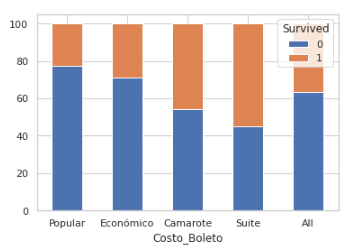

In [63]:
 #Principales estadísticos de la variable edad:

X_train_full['Fare'].describe()

In [64]:
# ¿Cuántos boletos fueron virtualmente gratis?

X_train_full[X_train_full['Fare']==0]

# se trata de sólo 15 boletos de los 891 que contiene el marco de datos (se obtiene al utilizar len()). Su efecto parece marginal y no hay un patron distinguible, 
# excepto que se trata de personas de género másculino, adultas en su mayoría. Quizá tripulación.

In [65]:
# Definamos una nueva variable que pueda modificarse, sin perder la información contenida en la original
X_train_full_modif = X_train_full

In [66]:
# Fare es nuestra segunda variable numérica

# para ver cómo se comporta la distribución veamos la boxplot, se tranforma monótonamente la variable con la función log() para efectos de mejorar la visutalización que está muy sezgada a la izquierda
# sin considerar los boletos de precio cero, que salen como indefinidos en la función log()
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=np.log(X_train_full_modif["Fare"]))

In [67]:
# En virtud de lo anterior, eliminemos los boletos con costo cero para efectos de hacer una transformación monotona con la función log() y mejorar la visualización.

list = X_train_full_modif[X_train_full_modif['Fare']==0].index


# for i in list:
#    X_train_full_modif.drop([i], axis=0, inplace=True)


In [68]:
costo = X_train_full['Fare']

plt.hist(costo)
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()
print(sts.normaltest(costo.sample(50)))

In [69]:
#calculemos la desviación estándar de la variable Fare
sd_numpy = np.std(costo,ddof = 0) # el parámetro ddof nos permite garantizar que estamos calculando la desviación estándar poblacional.
print(f"La desviación estándar poblacional del costo del boleto es: {sd_numpy}")

In [70]:
# calculamos la media
mean_numpy = np.mean(costo)
print(f"La media de las edades es: {mean_numpy}")


In [71]:
# Calculemos la regla empírica 68-95-99.7 usando desviación estándar
print(f"Aproximadamente 68% de los datos está entre: {round(mean_numpy-sd_numpy,3)} and {round(mean_numpy+sd_numpy,3)}")
print(f"Aproximadamente el 95% de los datos está entre: {round(mean_numpy-2*sd_numpy,3)} and {round(mean_numpy+2*sd_numpy,3)}")
print(f"Aproximadamente el 99.7% de los datos está entre: {round(mean_numpy-3*sd_numpy,3)} and {round(mean_numpy+3*sd_numpy,3)}")

In [72]:
# buscando los aberrantes a través del método intercuartílico
quartiles = costo.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

In [73]:
# El valor de 1.5 se deriva de las reglas de distribución normal. El cálculo algebráico está disponible en: 

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Valores por debajo de {np.exp(lower_bound)} son datos aberrantes.")
print(f"Valores por encima de {np.exp(upper_bound)} son datos aberrantes.")


In [74]:
# Los datos aberrantes de acuerdo al análisis de rango intercuantílico son:

X_train_full[X_train_full['Fare']>245.19]

**Hemos visto indicios de la relevancia del costo del boleto para explicar la sobrevivencia como variable aleatoria, exploremos la tablas de contingencia, pero antes debemos crear los bins de los ingresos. En otras palabras, crear una variable categórica basada en los costos de los boletos y considerando los siguientes valores posibles: Bebé, Niño Pequeño (comienza a caminar), Niño, Adolecente y Adulto.**

In [75]:
# para ello utilizaremos la función de pandas qcut en los términos señalados en: https://pbpython.com/pandas-qcut-cut.html

X_train_full['Fare'].describe()


In [76]:
# Calculando los bins con 6 cuantiles

pd.qcut(X_train_full['Fare'], q=6)

**¿Cuáles son los bins óptimos?**

El número de cuantiles óptimo debe estar determinado por los tabuladores de precios de los boletos disponibles en Internet. En particular el previsto en: https://historyanswers.com/what-were-the-titanic-ticket-prices/


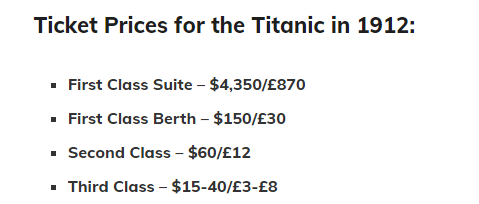



In [77]:
# Usando el método cut de pandas
# Este método utiliza la información de la distribución y divide en rangos iguales las categorías y acomoda los datos de acuerdo a ello

pd.Series(pd.cut(X_train_full['Fare'], 4)).value_counts()

In [78]:
# Dada la distribución automática realizada por el método cut y la necesidad de reflejar mejor el costo del boleto en categorías adecuadas 

etiquetas = ['Popular', "Económico", 'Camarote', 'Suite']
cut_bins =[0, 8, 14.5, 32, 100] # Basados en los quartiles de la distribución y los precios publicados en Internet por clase del viaje.
X_train_full['Costo_Boleto'] = pd.cut(X_train_full['Fare'], bins=cut_bins, labels = etiquetas)

In [79]:
X_train_full['Costo_Boleto'].value_counts()

Estamos listos para ver las tablas de contingencia:

In [80]:
# Sobrevivir vs. costo del boleto
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Costo_Boleto'], margins=True)

In [81]:
pd.crosstab(index=X_train_full['Survived'], columns=X_train_full['Costo_Boleto'], margins=True, normalize='index')\
    .round(4)*100


In [82]:
pd.crosstab(index=X_train_full['Costo_Boleto'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100


In [83]:
crosstab_clase = pd.crosstab(index=X_train_full['Costo_Boleto'], columns=X_train_full['Survived'], margins=True, normalize='index')\
    .round(4)*100

crosstab_clase.plot(kind="bar", stacked=True, rot=0)

## <span style="color:blue">Paso 4 *(Pre-Procesamiento)*:</span>

## En este punto ya tenemos claridad sobre la relación de las variables disposibles con la variable a pronósticar (Sobrevivir). 

## ¡Ahora vamos a preparar los datos para modelar!

In [84]:
# primero eliminemos aquellas variables que consideramos que no tienen valor estadístico relevante "Name" y "Ticket" 
# (me hubiése gustado explorar la variable ticket para ver si tenía patrones interesantes, pero por falta de tiempo la eliminamos)
X_train_full.drop(['Name',  'Ticket'], axis=1,inplace=True)

# vamos a conservar los datos numéricos para ver si hacen la diferencia en la modelación o nos quedamos con las variables categóricas.

In [85]:
X_train_full.info()

In [86]:
# Obtengamos los conjuntos de datos de entranamiento y validación de la matriz de features explicativos y de la variable a explicar o pronosticar
X = X_train_full
# Eliminamos la variable a pronosticar de la base original

X.dropna(axis=0, subset=['Survived'], inplace=True)
y = X.Survived              
X.drop(['Survived'], axis=1, inplace=True)





In [87]:
# Romper el conjunto de validación del conjunto de datos de entrenamiento
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [88]:
# Es importante confirmar que nuestras variables categóricas tienen baja "cardinalidad" con valores únicos menores a 10, lo anterior porque si utilizamos la metodología de one-hot encoding
# podríamos tener un sobredimensionamiento que para efectos del modelo reduciría su precisión.

categorical = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'GrupoEdad', 'Costo_Boleto']
                       
for i in categorical:
    unique = X_train_full[i].unique()
    print(i, unique)

### Identificando las variables categóricas y numéricas.

In [89]:
columnas_categoricas = [col for col in X_train_full.columns if
                    X_train_full[col].nunique() < 10 and 
                    X_train_full[col].dtype in ["object","category"]]



In [90]:
columnas_categoricas

In [91]:
# # Select numerical columns
columnas_numericas = [col for col in X_train_full.columns if 
                X_train_full[col].dtype in ['int64', 'float64']]

In [92]:
columnas_numericas

In [93]:
# Keep selected columns only
my_cols = columnas_categoricas + columnas_numericas
my_cols

In [94]:
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
#X_test = X_test_full[my_cols].copy() # estoy valorando si subo el resultado a la competencia

In [95]:
X_train.head()

In [96]:
# número de missings en el conjunto de entrenamiento
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Urge una imputación de missing values, en particular para el grupo de edad y el costo de los boletos

In [97]:
# imputación de missing values con la media de la distribución y conforme a lo aprendido en el curso
final_imputer = SimpleImputer(strategy='most_frequent')

imputed_X_train = pd.DataFrame(final_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(final_imputer.transform(X_valid))

# devolvemos el nombre de las columnas porque el método de imputación las elimina

imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns


In [98]:
missing_val_count_by_column = (imputed_X_train.isnull().sum())
missing_val_count_by_column2 = (imputed_X_valid.isnull().sum())
print(f'missings totales en el conjunto de entrenamiento: {missing_val_count_by_column[missing_val_count_by_column > 0]}')
print(f'missings totales en el conjunto de validación: {missing_val_count_by_column2[missing_val_count_by_column2 > 0]}')

In [99]:
imputed_X_train.head()

In [100]:
imputed_X_valid.head()

Antes de aplicar la técnica de one-hot encoding, vamos a eliminar las referencias numéricas en las etiquetas de las bariables tipo 'Object' y 'category'

In [101]:
# creemos un diccionario para reemplazar etiquetas:

categorical = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'GrupoEdad', 'Costo_Boleto']
                       
for i in categorical:
    unique = imputed_X_train[i].unique()
    print(i, unique)

In [102]:
nuevas_etiquetas = {"Pclass":     {1: "Primera clase", 2:"Segunda clase", 3: "Tercera Clase"},
                    "SibSp": {0: "sin", 1: "hemano", 2: "hermana", 3:"hermanastro", 4:"Hermanastra",
                              5: "esposo", 8: "esposa"},
                   "Parch": { 0: "nana", 1: "mamá", 2: "papá", 3: "hija", 4: "hijo", 5: "hijastra", 6:"hijastro"}}

imputed_X_train = imputed_X_train.replace(nuevas_etiquetas)
imputed_X_train.head()

In [103]:
# mismo tratamiento para el conjunto de validación

categorical = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'GrupoEdad', 'Costo_Boleto']
                       
for i in categorical:
    unique = imputed_X_valid[i].unique()
    print(i, unique)

In [104]:
imputed_X_valid = imputed_X_valid.replace(nuevas_etiquetas)
imputed_X_valid.head()

In [105]:
# veamos la variable y en términos de missing values y necesidad de imputar

missing_val_count_y_train = y_train.isnull().sum()
print(missing_val_count_y_train)
missing_val_count_y_valid = y_valid.isnull().sum()
print(missing_val_count_y_valid)


In [106]:
y_train.value_counts
y_valid.value_counts

In [107]:
# no es necesario el tratamiento de missings pero sí sustituir etiquetas en ambos conjuntos de datos:

y_train = y_train.replace({1: "Sobrevivió"})
y_train = y_train.replace({0: "No sobrevivió"})
y_train



In [108]:
# mismo tratamiento para el conjunto de la variable explicada destinado a la validación
y_valid = y_valid.replace({1: "Sobrevivió"})
y_valid = y_valid.replace({0: "No sobrevivió"})
y_valid



El siguiente paso consiste en aplicar el método one-hot encoding en los marcos de datos X para el correcto tratamiento de las variables categóricas, buscando siempre un mejor ajuste del modelo. Aplicamos los pasos aprendidos.

In [109]:
# Antes, regresemos las columnas Age y Fare a numericas

imputed_X_train['Age'] = imputed_X_train['Age'].astype('float64')
imputed_X_train['Fare'] = imputed_X_train['Fare'].astype('float64')
imputed_X_train.dtypes

In [110]:
# Antes, regresemos las columnas Age y Fare a numericas

imputed_X_valid['Age'] = imputed_X_valid['Age'].astype('float64')
imputed_X_valid['Fare'] = imputed_X_valid['Fare'].astype('float64')
imputed_X_valid.dtypes

In [111]:
# Columnas que podrían ser sujetas al one-hot encoding

object_cols = [col for col in imputed_X_train.columns if imputed_X_train[col].dtype == "object"]

baja_cardinalidad_cols = [col for col in object_cols if imputed_X_train[col].nunique() < 10]

# columnas que serán borradas del conjunto de datos
#high_cardinality_cols = list(set(object_cols)-set(baja_carninalidad_cols))

print('Columnas categóricas que serán sujetas a one-hot encoding:', baja_cardinalidad_cols)
#print('\nVariables categóricas que serán borradas del conjunto de datos de entrenamiento:', high_cardinality_cols)

# Podemos predecir que ninguna columna será borrada y se repite el caso para el conjunto imputed_X_valid

In [208]:
imputed_X_train

In [112]:
# Aplicando one-hot encoder a cada columna con datos categóricos
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_X_train[baja_cardinalidad_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_X_valid[baja_cardinalidad_cols]))

# One-hot encoding elimina el index; hay que ponerlo de vuelta
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Quitar las variables categoricas (para reemplazar con one-hot encoding)
num_X_train = imputed_X_train.drop(object_cols, axis=1)
num_X_valid = imputed_X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = OH_cols_train # pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = OH_cols_valid #pd.concat([num_X_valid, OH_cols_valid], axis=1) # En virtud de que hemos creado las variables categóricas y el modelo de regresión logística sugiere evitar multicolinealidad.
# no tomaremos en cuenta los valores numéricos.

In [207]:
OH_cols_train

In [114]:
# imputemos los missings en cada variables OH

# imputación de missing values con la media de la distribución y conforme a lo aprendido en el curso
final_imputer = SimpleImputer(strategy='most_frequent')

imputed_OH_X_train = pd.DataFrame(final_imputer.fit_transform(OH_X_train))
imputed_OH_X_valid = pd.DataFrame(final_imputer.transform(OH_X_valid))

# devolvemos el nombre de las columnas porque el método de imputación las elimina

imputed_OH_X_train.columns = OH_X_train.columns
imputed_OH_X_valid.columns = OH_X_valid.columns


In [206]:
 
OH_X_train.isnull().sum()

In [146]:
# Recuperendo el nombre de las columnas

OH_X_train.columns = OH_encoder.get_feature_names()
OH_X_train

In [147]:
OH_X_valid.columns = OH_encoder.get_feature_names()
OH_X_valid

## <span style="color:blue">Paso 5 *(Definiendo y entrenando el modelo, haciendo predicciones y evaluando precisión)*:</span>

## Hemos realizado el tratamiento requerido a los missing values (imputación) y las variables categóricas (one-hot encoding). 

## ¡Vamos a definir el modelo, entrenar el modelo, hacer predicciones y evaluar la precisión del mismo!

El modelo elegido, de acuerdo a los requerimientos del proyecto integrador, es la regresión logística. Un algorítmo para predecir la probabilidad de sobrevivir como variable binaria P(Y=1) como función de aquellas variables relevantes que hemos venido estudiando previamente. Para evitar la multicolinealidad, se eliminan las variables numéricas y se privilegian las variables categóricas construidas previamente (GrupoEdad y Costo_Boleto).

Continuaré buscando aumentar la precisión del modelo de regresión logística, en la primera Opción A se logra un score de 80, donde podemos ver que tenemos 22 falsos negativos (el modelo los pronóstica como fallecidos cuando en realidad sobrevvivieron) y 13 falsos positivos. 

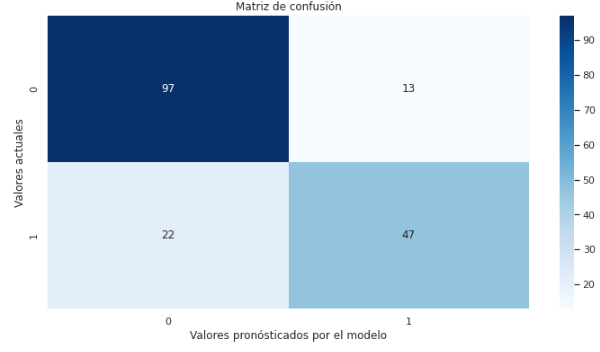

# Modelo de Regresión Logística

Dado que la implementación de la regresión logística de sklearn utiliza la
regularización, necesitamos escalar nuestros datos de características. Cree
un objeto StandardScaler, y emplee .fit_transform() en las
características de entrenamiento y .transform() en las características de
prueba.

Para el planteamiento del modelo logístico, se utilizó como referencia el siguiente artículo: Logistic Regression with StandardScaler-From the Scratch https://medium.com/@draj0718/logistic-regression-with-standardscaler-from-the-scratch-ec01def674e8.

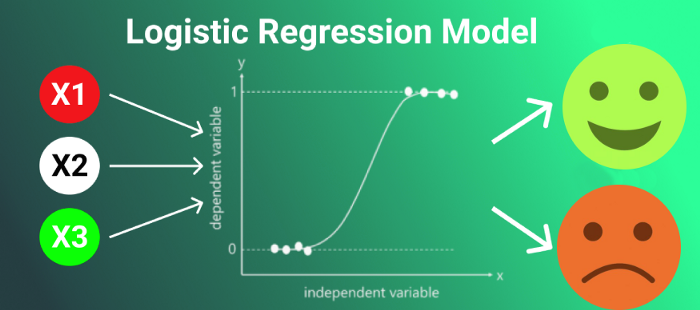


In [148]:
# En particular este tipo de modelos son sensibles a la magnitud de las variables, situación que proporciona más peso a las variables con mayor monto, es por este motivo que debemos estadarizar
#  Cree un objeto StandardScaler, y emplee .fit_transform() en las características de entrenamiento y .transform() en las características de prueba.

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(OH_X_train)
X_valid = sc.transform(OH_X_valid)


In [149]:
X_train

In [150]:
X_valid

In [151]:
# Entranando al modelo

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 10,solver='liblinear') # elijo liblinear debido a la documentación en sklearn https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# se trata de un algorítmo apropiado para pequeños conjuntos de datos
classifier.fit(X_train, y_train)

In [152]:
# Haciendo las predicciones para medir la precisión del mismo

y_pred = classifier.predict(X_valid)
test_acc = accuracy_score(y_valid, y_pred)
print(f'The Accuracy for Test Set is {test_acc*100}')

In [121]:
# Utilizando una matriz de confusión para gráficar 

cm=confusion_matrix(y_valid,y_pred)
plt.figure(figsize=(12,6))
plt.title('Matriz de confusión')
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel('Valores actuales')
plt.xlabel('Valores pronósticados por el modelo')

### Con los datos de la matriz de confusión podemos calcular otras métricas para valorar el desempeño del modelo:

### Desempeño total del modelo 

### TP: Verdaderos positivos, TN: Verdaderos negativos, FP: Falsos positivos y FN: Falsos negativos


In [122]:
tp = 47
tn = 97
fp = 22
fn = 13

Dt = (tp+tn)/(tp+tn+fp+fn)

Precisión = tp/(tp/fp)

Recuerdo = tp/(tp+fn)

Especificidad = tn/(tn+fp)

print(f'Desempeño total del modelo = {Dt}')
print(f'Qué tan preciso es en el cálculo de los positivos = {Precisión}') # La habilidad del clasificador para 
print(f'Cobertura de los positivos = {Recuerdo}')
print(f'Cobertura de los negativos = {Especificidad}')

Imprimamos los coeficientes de característica del modelo para visualizar cuáles fueron los más importantes



In [123]:
print(classifier.coef_, classifier.intercept_)

In [124]:
# Calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred,
                            target_names=["Sobrevivió", "No Sobrevivió"]))

In [125]:
pd.DataFrame({"Predicción": y_pred, "Actual": y_valid})

# Para identificar las características más importantes

Utilizamos el código provisto por https://learn.theprogrammingfoundation.org/getting_started/intro_data_science/module4/?gclid=CjwKCAjwwdWVBhA4EiwAjcYJEFqnlDI2VDy0SjU9PuP3fR0AdjVmGy2zvVhOh2BmPnJiIX1dmakz3xoC2E0QAvD_BwE 

In [129]:
X_train

In [153]:
feature_names = OH_X_train.columns.to_list()
feature_names

## <span style="color:red">Como vimos en clase, el coeficiente nos proporciona el cambio marginal de la variable a explicar o pronósticar (sobrevivir o no sobrevivir) derivado de un cambio en la variable explicativa (feature o caracterísitica) ***ceteris paribus*** (todo lo demás constante). En este sentido, la variable con un mayor coeficiente tiene mayor poder explicativo y, por consiguiente, es más relevante.</span>

# En este sentido, encontrarás una visualización en función del coeficiente resultante para cada característica incluida en el modelo, definidas como b1.

Como se verá más abajo, el resultado es que los criterios con mayor peso o mejor poder explicativo de la probabilidad de sobrevivir son, en orden de aparición: 

1. El tripulante es un bebé (Entre cero y menos de 2 años de edad)
2. El tripulante es una mujer
3. El tripulante viaja sólo, sin algún familiar o cercano en el barco.
4. El tripulate viaja con un hermano.
5. El tripulate pertenece a la primera clase.
6. Se trata de un niño de entre 4 y 13 años de edad.
7. El tripulate tiene a su mamá en el barco.
8. El tripulate viaja sólo únicamente con su nana (por ende se entiende que es un menor de edad).
9. El tripulante tiene una hermana en el barco.
10.El tripulante tiene una hija en el barco.
11. El tripulante es un toddler (entre 2 y 4 años de edad)

Es relevante señalar que ni el ser anciano, hombre o tercera clase se consideran variables con un peso mayor para explicar la probabilidad de sobrevivir (situación que esperabamos en función del EDA realizado arriba).

In [165]:
# Entrenando el modelo y logrando mejor score y obteniendo intercepto y coeficientes de cada característica.

model = classifier = LogisticRegression(random_state = 10,solver='liblinear').fit(OH_X_train[feature_names].values, y_train) 
score = model.score(OH_X_train[feature_names].values, y_train)
print(f'mejoramos el score al no utilizar scaler: {score}')
b0 = model.intercept_[0]
b1 = model.coef_[0]
print(f'El intercepto de la estimación es: {b0}')
print(f'Los coeficientes de las 32 caracterísitcas explicativas en la función estimada son: {b1}')


In [171]:
# Obteniendo la importancia de las caracterísitcas en función de sus parámetros

features_importance = pd.DataFrame(feature_names, columns = ['Feature'])
features_importance['importance'] = pow(math.e,b1) # se utiliza la función exponencial dada la definición del modelo de regresión logística
features_importance = features_importance.sort_values(by=['importance'], ascending= False)
features_importance

In [175]:
# visualicemos los datos

import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=features_importance['Feature'],
            y=features_importance['importance'],
            orientation='v'))

fig.show()

## <span style="color:blue">Paso 6 *(Proveer características de tres sujetos, en ellos incluido y ver quién se hundiría y quién no)*:</span>


In [248]:
# para hacerlo consistente con las categorías que construimos en la sección EDA, 
# bins = [0,2,4,13,18,50,80]
# etiquetas = ['Bb', 'Peque', 'Niño', 'Adolecente', 'Adulto', 'Anciano']
# Tenemos que Jack es un adulto, Rose es adolecente y yo Adulto :)

# Jack = np.array([Male,Adulto,0.0,0.0])
# Rose = np.array([Female,Adolecente,1.0,0.0])
# You = np.array([Male,Adulto,___,___])


input_users = {'Jack': {'x0_Primera Clase': 0.0, 'x0_Segunda clase': 0.0,"x1_female": 0.0,"x1_male": 1.0, "x5_Adolecente": 0.0, "x5_Adulto":1.0},
            'Rose':{'x0_Primera Clase': 1.0, 'x0_Segunda clase': 0.0,"x1_female": 1.0,"x1_male": 0.0, "x5_Adolecente": 1.0, "x5_Adulto":0.0},
            'Rodrigo Guarneros': {'x0_Primera Clase': 0.0, 'x0_Segunda clase': 1.0,"x1_female": 0.0,"x1_male": 1.0, "x5_Adolecente": 0.0, "x5_Adulto":1.0}}



In [200]:
sample_passengers = pd.DataFrame(input_users).T
sample_passengers

In [242]:
sc = StandardScaler()
sample_passengers2 = sc.fit_transform(sample_passengers)




In [210]:
sample_passengers2

Antes de predecir hagamos entrenemos un modelo únicamente con las características provistas para esta muestra


In [243]:
# Usamos OH_X_train para el entrenamiento del modelo. Eliminemos estas variables adicionales

col_original = ['x0_Primera clase', 'x0_Segunda clase', 'x1_female',
       'x1_male','x5_Adolecente', 'x5_Adulto']

OH_X_train_reducido = OH_X_train[col_original]
OH_X_valid_reducido = OH_X_valid[col_original]

OH_X_train_reducido

In [244]:
# Aplicamos el scaler para el conjunto de datos reducidos

sc = StandardScaler()
X_train_reducido = sc.fit_transform(OH_X_train_reducido)
X_valid_reducido = sc.fit_transform(OH_X_valid_reducido)



In [219]:
X_train_reducido

In [245]:
# entrenamos el modelo con los datos de entrenamiento reducidos

classifier.fit(X_train_reducido, y_train)

In [226]:
y_pred = classifier.predict(X_valid_reducido)
test_acc = accuracy_score(y_valid, y_pred)
print(f'The Accuracy for Test Set is {test_acc*100}')

# con estas pocas variables el pronóstico no es tan preciso. No obstante se utilizará el modelo para pronósticar a los datos muestra

In [246]:
probabilidades = classifier.predict_proba(sample_passengers2)
probabilidades

In [247]:
sample_passengers_prediction = classifier.predict(sample_passengers2)
sample_passengers_prediction

pd.DataFrame({"Nombre": sample_passengers.index, "Predicción": sample_passengers_prediction, "Probabilidades (No sobrevivir, Sobrevivir)": probabilidades.tolist()})

# por el peso o efecto marginal de cada variable, Rose como mujer adolecente de primera clase tiene más probabilidades de sobrevivir
# En mi caso y en el de Jack, Siendo Hombres, adultos y de segunda y tercera clase, no sobreviviríamos, incluso si ambos nos cambiaramos a primera clase de acuerdo con los resultados del modelo.

# Bibliografía y recursos consultados

- **How to Get Started with Kaggle’s Titanic Competition | Kaggle.** Disponible en: https://youtu.be/8yZMXCaFshs
- **The Titanic’s Route – From Shipyard to Sinking (Via Southampton, Cherbourg and Queenstown)**. Disponible en: https://emmacruises.com/titanic-route-and-port-stops/
- **6 different ways to compensate for missing values data imputation with examples.** Disponible en https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
- **Handling Categorical Data, The Right Way.** Disponible en: https://towardsdatascience.com/handling-categorical-data-the-right-way-9d1279956fc6
- **Exploratory Data Analysis done right.** Disponible en: https://medium.com/uttiyamaji/exploratory-data-analysis-done-right-dfb15e0e2b94
- **Passengers of the Titanic (Wikipedia).** Disponible en: https://en.wikipedia.org/wiki/Passengers_of_the_Titanichttps://en.wikipedia.org/wiki/Passengers_of_the_Titanic
- **How Much Was A Ticket On The Titanic?** Disponible en: https://www.cruisemummy.co.uk/titanic-ticket-prices/
- **Binning for Feature Engineering in Machine Learning.** Disponible en: https://towardsdatascience.com/binning-for-feature-engineering-in-machine-learning-d3b3d76f364a
- **What Were The Titanic Ticket Prices?** Disponible en: https://historyanswers.com/what-were-the-titanic-ticket-prices/
- **Data Binning with Pandas Cut or Qcut Method.** Disponible en: https://towardsdatascience.com/sort-and-segment-your-data-into-bins-to-get-sorted-ranges-pandas-cut-and-qcut-7785931bbfde
- **Logistic Regression with StandardScaler-From the Scratch.** Disponible en: https://medium.com/@draj0718/logistic-regression-with-standardscaler-from-the-scratch-ec01def674e8
- **The Programming Foundation**. Disponible en: https://learn.theprogrammingfoundation.org/getting_started/intro_data_science/module4/?gclid=CjwKCAjwwdWVBhA4EiwAjcYJEFqnlDI2VDy0SjU9PuP3fR0AdjVmGy2zvVhOh2BmPnJiIX1dmakz3xoC2E0QAvD_BwE